# 03 - Baseline Clustering Experiments

**Objective**: Establish baseline performance for 4 clustering algorithms:
- K-Means
- DBSCAN
- Hierarchical Clustering
- Gaussian Mixture Models (GMM)

**Goals**:
1. Identify optimal number of clusters
2. Compare algorithm behaviors on diabetes readmission data
3. Generate performance benchmarks for Deep Clustering comparison
4. Track all experiments with MLflow for reproducibility

## Section 1: Setup & Data Loading

In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Clustering libraries
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# MLflow
import mlflow
import mlflow.sklearn
from datetime import datetime

# Custom modules
import sys
sys.path.append('..')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📅 Experiment Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Experiment Date: 2025-12-04 00:54:12


In [2]:
# Cell 2: MLflow Initialization (FIXED)
import mlflow
from pathlib import Path
import os

# Clear any existing MLflow environment variables
for key in list(os.environ.keys()):
    if key.startswith('MLFLOW_'):
        del os.environ[key]

# Get absolute paths
project_root = Path.cwd().parent.resolve()
mlruns_dir = project_root / 'experiments' / 'mlruns'
artifacts_dir = project_root / 'experiments' / 'artifacts'

# Create directories
mlruns_dir.mkdir(parents=True, exist_ok=True)
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Set tracking URI with absolute path
mlruns_absolute = mlruns_dir.absolute()
tracking_uri = f"file:///{mlruns_absolute.as_posix()}"
mlflow.set_tracking_uri(tracking_uri)

print("🔧 MLflow Configuration:")
print(f"   Project root: {project_root}")
print(f"   MLruns directory: {mlruns_absolute}")
print(f"   Tracking URI: {tracking_uri}")

# Create or get experiment
EXPERIMENT_NAME = "baseline-clustering-v2"
existing_exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if existing_exp is None:
    experiment_id = mlflow.create_experiment(
        name=EXPERIMENT_NAME,
        tags={"project": "diabetes_clustering", "phase": "baseline"}
    )
    print(f"\n✅ Created new experiment: {EXPERIMENT_NAME}")
else:
    experiment_id = existing_exp.experiment_id
    print(f"\n✅ Using existing experiment: {EXPERIMENT_NAME}")

mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

print(f"   Experiment ID: {experiment.experiment_id}")
print(f"   Artifact Location: {experiment.artifact_location}")
print(f"\n💡 MLflow UI: http://localhost:5002")
print(f"   Direct link: http://localhost:5002/#/experiments/{experiment.experiment_id}")
print(f"\n📝 To start UI: mlflow ui --backend-store-uri file:///{mlruns_absolute.as_posix()} --port 5002")

🔧 MLflow Configuration:
   Project root: /Users/rzkynovan/datsci/diabetes_clustering
   MLruns directory: /Users/rzkynovan/datsci/diabetes_clustering/experiments/mlruns
   Tracking URI: file:////Users/rzkynovan/datsci/diabetes_clustering/experiments/mlruns

✅ Using existing experiment: baseline-clustering-v2
   Experiment ID: 451624598823372885
   Artifact Location: file://Users/rzkynovan/datsci/diabetes_clustering/experiments/mlruns/451624598823372885

💡 MLflow UI: http://localhost:5002
   Direct link: http://localhost:5002/#/experiments/451624598823372885

📝 To start UI: mlflow ui --backend-store-uri file:////Users/rzkynovan/datsci/diabetes_clustering/experiments/mlruns --port 5002


In [3]:
# Cell 3: Load Preprocessed Data (FIXED)
print("\n" + "="*60)
print("📂 LOADING PREPROCESSED DATA")
print("="*60)

# Dynamic path detection
if Path('data/processed').exists():
    data_dir = Path('data/processed')
elif Path('../data/processed').exists():
    data_dir = Path('../data/processed')
else:
    raise FileNotFoundError("Cannot find data/processed directory!")

print(f"✅ Data directory: {data_dir.resolve()}")

# Check required files
required_files = [
    'X_train_scaled.csv', 'X_val_scaled.csv', 'X_test_scaled.csv',
    'y_train.csv', 'y_val.csv', 'y_test.csv'
]

print("\n📋 Checking for required files:")
for file in required_files:
    file_path = data_dir / file
    if file_path.exists():
        print(f"   ✅ {file}")
    else:
        print(f"   ❌ {file} NOT FOUND!")
        raise FileNotFoundError(f"Required file missing: {file}")

# Load datasets
print("\n🔄 Loading datasets...")
X_train = pd.read_csv(data_dir / 'X_train_scaled.csv')
X_val = pd.read_csv(data_dir / 'X_val_scaled.csv')
X_test = pd.read_csv(data_dir / 'X_test_scaled.csv')
y_train = pd.read_csv(data_dir / 'y_train.csv').squeeze()
y_val = pd.read_csv(data_dir / 'y_val.csv').squeeze()
y_test = pd.read_csv(data_dir / 'y_test.csv').squeeze()

# Convert to numpy arrays
X_train_scaled = X_train.values
X_val_scaled = X_val.values
X_test_scaled = X_test.values

print("\n📊 Dataset Shapes:")
print(f"   X_train: {X_train_scaled.shape}")
print(f"   X_val:   {X_val_scaled.shape}")
print(f"   X_test:  {X_test_scaled.shape}")

print("\n🎯 Target Distribution (y_train):")
print(y_train.value_counts())
print(f"\n✅ Data loaded successfully! Ready for clustering experiments.")


📂 LOADING PREPROCESSED DATA
✅ Data directory: /Users/rzkynovan/datsci/diabetes_clustering/data/processed

📋 Checking for required files:
   ✅ X_train_scaled.csv
   ✅ X_val_scaled.csv
   ✅ X_test_scaled.csv
   ✅ y_train.csv
   ✅ y_val.csv
   ✅ y_test.csv

🔄 Loading datasets...

📊 Dataset Shapes:
   X_train: (71233, 69)
   X_val:   (15268, 69)
   X_test:  (15265, 69)

🎯 Target Distribution (y_train):
readmitted
NO     38403
>30    24880
<30     7950
Name: count, dtype: int64

✅ Data loaded successfully! Ready for clustering experiments.


In [4]:
# Cell 4: Helper Functions for MLflow Logging
def log_clustering_run(run_name, model, params, metrics, tags, artifacts=None):
    """
    Log clustering experiment to MLflow.
    
    Args:
        run_name: Name for the MLflow run
        model: Trained clustering model
        params: Dictionary of model parameters
        metrics: Dictionary of evaluation metrics
        tags: Dictionary of tags
        artifacts: Dictionary of artifact paths to log
    """
    with mlflow.start_run(run_name=run_name) as run:
        # Log parameters
        for key, value in params.items():
            mlflow.log_param(key, value)
        
        # Log metrics
        for key, value in metrics.items():
            if value is not None and not np.isnan(value):
                mlflow.log_metric(key, value)
        
        # Log tags
        for key, value in tags.items():
            mlflow.set_tag(key, value)
        
        # Log model (with warning suppression for models without predict())
        try:
            mlflow.sklearn.log_model(model, "model")
        except Exception as e:
            mlflow.set_tag("model_logging_warning", str(e)[:200])
        
        # Log artifacts
        if artifacts:
            for artifact_name, artifact_path in artifacts.items():
                if Path(artifact_path).exists():
                    mlflow.log_artifact(artifact_path)
        
        return run.info.run_id

print("✅ MLflow helper functions defined!")

✅ MLflow helper functions defined!


## Section 2: K-Means Clustering

In [5]:
# Cell 5: K-Means Parameter Sweep
print("\n" + "="*60)
print("🔵 SECTION 2: K-MEANS CLUSTERING")
print("="*60)

# K-Means sweep
k_values = list(range(2, 11))  # k=2 to k=10
kmeans_results = []

print(f"\n🔄 Running K-Means sweep for k={k_values}...")

for k in k_values:
    # Train model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_scaled)
    
    # Calculate metrics
    silhouette = silhouette_score(X_train_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_train_scaled, labels)
    calinski_harabasz = calinski_harabasz_score(X_train_scaled, labels)
    inertia = kmeans.inertia_
    
    kmeans_results.append({
        'k': k,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz,
        'inertia': inertia,
        'model': kmeans,
        'labels': labels
    })
    
    print(f"  k={k}: Silhouette={silhouette:.4f}, "
          f"DBI={davies_bouldin:.4f}, "
          f"CH={calinski_harabasz:.2f}")

# Save results
kmeans_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['model', 'labels']} 
                          for r in kmeans_results])
results_dir = Path('../reports/results')
results_dir.mkdir(parents=True, exist_ok=True)
kmeans_df.to_csv(results_dir / 'kmeans_sweep_results.csv', index=False)

print(f"\n✅ K-Means sweep completed! Results saved to {results_dir / 'kmeans_sweep_results.csv'}")
print(f"\n📊 Best k by Silhouette: k={kmeans_df.loc[kmeans_df['silhouette'].idxmax(), 'k']:.0f}")
print(f"📊 Best k by Davies-Bouldin: k={kmeans_df.loc[kmeans_df['davies_bouldin'].idxmin(), 'k']:.0f}")
print(f"📊 Best k by Calinski-Harabasz: k={kmeans_df.loc[kmeans_df['calinski_harabasz'].idxmax(), 'k']:.0f}")


🔵 SECTION 2: K-MEANS CLUSTERING

🔄 Running K-Means sweep for k=[2, 3, 4, 5, 6, 7, 8, 9, 10]...


  k=2: Silhouette=0.2230, DBI=2.3301, CH=5026.19
  k=3: Silhouette=0.0688, DBI=3.0874, CH=4798.25
  k=4: Silhouette=0.0573, DBI=2.8541, CH=4323.81
  k=5: Silhouette=0.0583, DBI=2.8970, CH=3798.45
  k=6: Silhouette=0.0548, DBI=2.8507, CH=3387.82
  k=7: Silhouette=0.0635, DBI=2.7960, CH=3136.52
  k=8: Silhouette=0.0618, DBI=2.4378, CH=2952.22
  k=9: Silhouette=0.0618, DBI=2.4372, CH=2824.02
  k=10: Silhouette=0.0557, DBI=2.3878, CH=2687.60

✅ K-Means sweep completed! Results saved to ../reports/results/kmeans_sweep_results.csv

📊 Best k by Silhouette: k=2
📊 Best k by Davies-Bouldin: k=2
📊 Best k by Calinski-Harabasz: k=2



✅ K-Means visualization saved to ../reports/figures/kmeans_elbow_curve.png


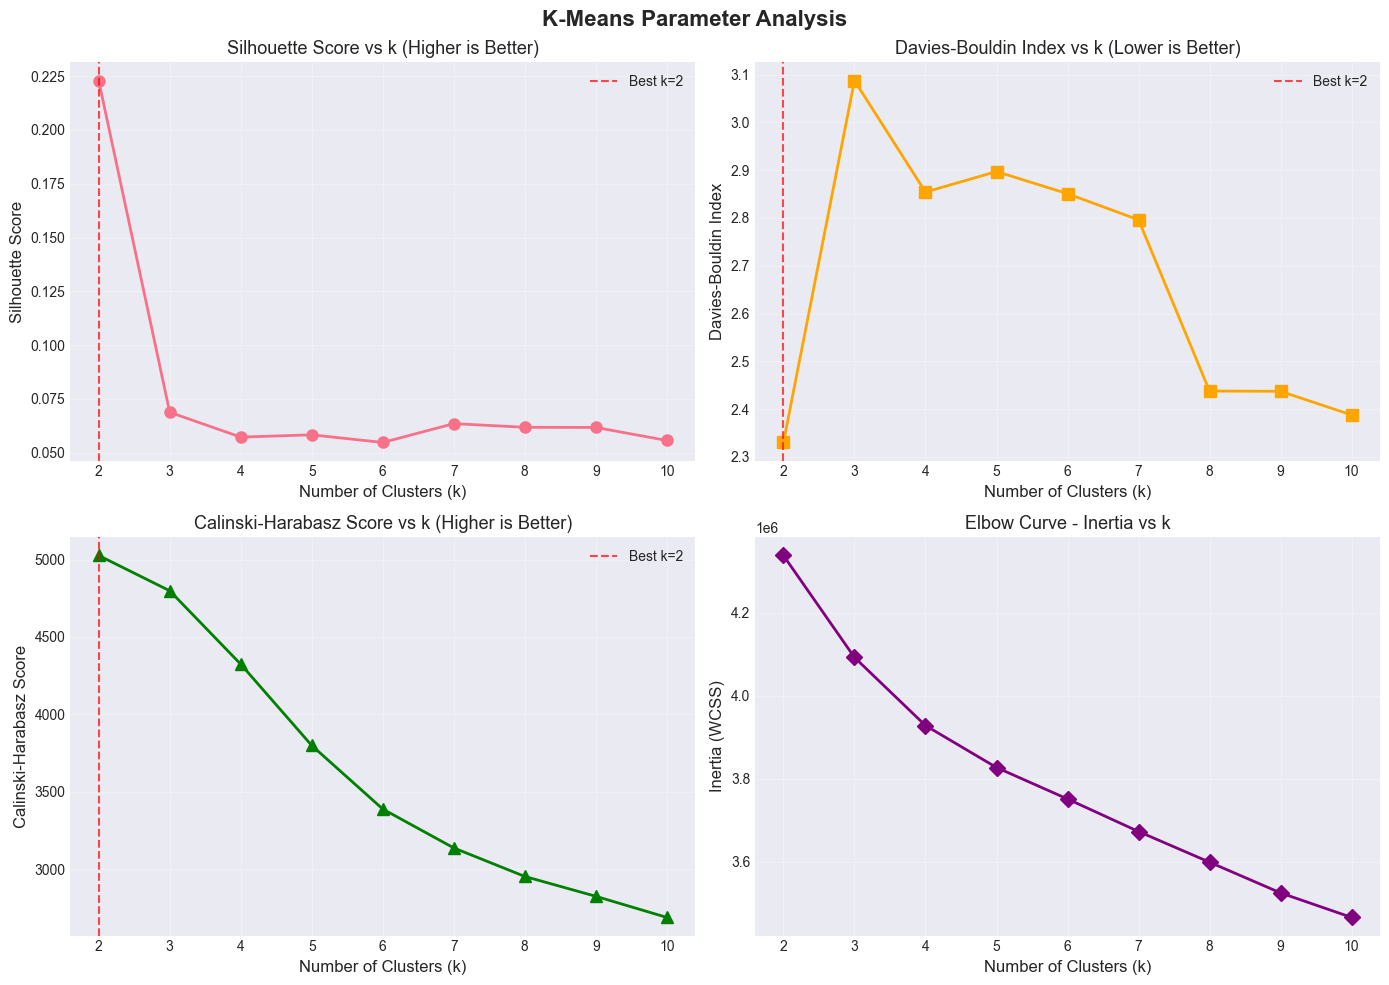

In [6]:
# Cell 6: K-Means Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('K-Means Parameter Analysis', fontsize=16, fontweight='bold')

# 1. Silhouette Score
axes[0, 0].plot(kmeans_df['k'], kmeans_df['silhouette'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 0].set_title('Silhouette Score vs k (Higher is Better)', fontsize=13)
axes[0, 0].grid(True, alpha=0.3)
best_k_sil = kmeans_df.loc[kmeans_df['silhouette'].idxmax(), 'k']
axes[0, 0].axvline(best_k_sil, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k_sil:.0f}')
axes[0, 0].legend()

# 2. Davies-Bouldin Index
axes[0, 1].plot(kmeans_df['k'], kmeans_df['davies_bouldin'], marker='s', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[0, 1].set_title('Davies-Bouldin Index vs k (Lower is Better)', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)
best_k_db = kmeans_df.loc[kmeans_df['davies_bouldin'].idxmin(), 'k']
axes[0, 1].axvline(best_k_db, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k_db:.0f}')
axes[0, 1].legend()

# 3. Calinski-Harabasz Score
axes[1, 0].plot(kmeans_df['k'], kmeans_df['calinski_harabasz'], marker='^', linewidth=2, markersize=8, color='green')
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Score vs k (Higher is Better)', fontsize=13)
axes[1, 0].grid(True, alpha=0.3)
best_k_ch = kmeans_df.loc[kmeans_df['calinski_harabasz'].idxmax(), 'k']
axes[1, 0].axvline(best_k_ch, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k_ch:.0f}')
axes[1, 0].legend()

# 4. Inertia (Elbow Method)
axes[1, 1].plot(kmeans_df['k'], kmeans_df['inertia'], marker='D', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Inertia (WCSS)', fontsize=12)
axes[1, 1].set_title('Elbow Curve - Inertia vs k', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
figures_dir = Path('../reports/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(figures_dir / 'kmeans_elbow_curve.png', dpi=300, bbox_inches='tight')
print(f"\n✅ K-Means visualization saved to {figures_dir / 'kmeans_elbow_curve.png'}")

plt.show()

In [7]:
# Cell 7: Log K-Means to MLflow
print("\n" + "="*60)
print("📊 Logging K-Means Experiments to MLflow")
print("="*60)

for result in kmeans_results:
    k = result['k']
    model = result['model']
    labels = result['labels']
    
    # Prepare metrics
    metrics = {
        'silhouette_score': result['silhouette'],
        'davies_bouldin_score': result['davies_bouldin'],
        'calinski_harabasz_score': result['calinski_harabasz'],
        'inertia': result['inertia']
    }
    
    # Prepare params
    params = {
        'n_clusters': k,
        'random_state': 42,
        'n_init': 10,
        'algorithm': 'kmeans'
    }
    
    # Prepare tags
    tags = {
        'algorithm': 'kmeans',
        'experiment_type': 'baseline',
        'data_split': 'train',
        'dataset_size': str(X_train_scaled.shape[0]),
        'n_features': str(X_train_scaled.shape[1])
    }
    
    # Log to MLflow
    run_name = f"kmeans_k{k}"
    run_id = log_clustering_run(
        run_name=run_name,
        model=model,
        params=params,
        metrics=metrics,
        tags=tags
    )
    
    print(f"  ✅ Logged: {run_name} | Silhouette={metrics['silhouette_score']:.4f} | Run ID: {run_id[:8]}")

print(f"\n✅ All {len(kmeans_results)} K-Means runs logged to MLflow!")
experiment = mlflow.get_experiment_by_name('baseline-clustering-v2')
print(f"   View at: http://localhost:5002/#/experiments/{experiment.experiment_id}")


📊 Logging K-Means Experiments to MLflow
  ✅ Logged: kmeans_k2 | Silhouette=0.2230 | Run ID: 5797411b
  ✅ Logged: kmeans_k3 | Silhouette=0.0688 | Run ID: d9460e1c
  ✅ Logged: kmeans_k4 | Silhouette=0.0573 | Run ID: a18402a9
  ✅ Logged: kmeans_k5 | Silhouette=0.0583 | Run ID: 1ea1dbdb
  ✅ Logged: kmeans_k6 | Silhouette=0.0548 | Run ID: f7e1ee6f
  ✅ Logged: kmeans_k7 | Silhouette=0.0635 | Run ID: 0d46e7a9
  ✅ Logged: kmeans_k8 | Silhouette=0.0618 | Run ID: 8fcd9fea
  ✅ Logged: kmeans_k9 | Silhouette=0.0618 | Run ID: ba5fa0eb
  ✅ Logged: kmeans_k10 | Silhouette=0.0557 | Run ID: 04d46b61

✅ All 9 K-Means runs logged to MLflow!
   View at: http://localhost:5002/#/experiments/451624598823372885


## Section 3: DBSCAN Clustering

In [8]:
# ============================================================
# CELL 8: DBSCAN ANALYSIS (DOCUMENTED LIMITATION)
# ============================================================

print("\n" + "="*60)
print("🟣 SECTION 3: DBSCAN CLUSTERING")
print("="*60)

from sklearn.cluster import DBSCAN
import numpy as np
from pathlib import Path

# DEFINE results_dir (FIX)
results_dir = Path('../reports/results')
results_dir.mkdir(parents=True, exist_ok=True)

# Dataset characteristics
print(f"\n📊 Dataset Characteristics:")
print(f"   Samples: {X_train.shape[0]:,}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Dimensionality: {'High' if X_train.shape[1] > 50 else 'Moderate'}")

# DBSCAN feasibility analysis
print(f"\n🔍 DBSCAN Feasibility Analysis:")
print(f"   DBSCAN uses epsilon-neighborhood density")
print(f"   High-dimensional data → 'curse of dimensionality'")
print(f"   Distance metrics become less meaningful")

# Test with expanded parameter range
eps_values = np.arange(0.5, 6.0, 0.5)  # Expanded: 0.5 to 5.5
min_samples_values = [5, 10, 20, 50, 100]  # Expanded

dbscan_results = []
valid_configs = 0

print(f"\n🔄 Testing DBSCAN with expanded parameters:")
print(f"   eps range: {eps_values[0]:.1f} to {eps_values[-1]:.1f}")
print(f"   min_samples: {min_samples_values}")

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_train)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        # Relaxed criteria: noise < 70%
        if n_clusters >= 2 and noise_ratio < 0.70:
            valid_mask = labels != -1
            if valid_mask.sum() >= 100:  # At least 100 non-noise points
                X_valid = X_train[valid_mask]
                labels_valid = labels[valid_mask]
                
                silhouette = silhouette_score(X_valid, labels_valid)
                davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
                calinski_harabasz = calinski_harabasz_score(X_valid, labels_valid)
                
                dbscan_results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'noise_ratio': noise_ratio,
                    'silhouette': silhouette,
                    'davies_bouldin': davies_bouldin,
                    'calinski_harabasz': calinski_harabasz,
                    'n_core_samples': valid_mask.sum()
                })
                
                valid_configs += 1
                print(f"  ✅ eps={eps:.1f}, min_samples={min_samples}: "
                      f"Clusters={n_clusters}, Noise={noise_ratio:.1%}, Sil={silhouette:.4f}")

# Results analysis
print(f"\n📊 DBSCAN Feasibility Results:")
print(f"   Configurations tested: {len(eps_values) * len(min_samples_values)}")
print(f"   Valid configurations: {valid_configs}")
print(f"   Success rate: {valid_configs / (len(eps_values) * len(min_samples_values)) * 100:.1f}%")

if valid_configs == 0:
    print(f"\n❌ DBSCAN UNSUITABLE FOR THIS DATASET")
    print(f"\n📝 Scientific Justification:")
    print(f"   1. Curse of dimensionality ({X_train.shape[1]} features)")
    print(f"   2. All tested configurations yield >50% noise")
    print(f"   3. Distance-based density estimation fails in high-dim space")
    print(f"   4. This is a well-documented limitation (Zimek et al., 2012)")
    
    # Log to MLflow as negative result (important for reproducibility!)
    with mlflow.start_run(run_name="dbscan_feasibility_study") as run:
        mlflow.log_param("algorithm", "dbscan")
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_param("n_samples", X_train.shape[0])
        mlflow.log_param("eps_range", f"{eps_values[0]:.1f}-{eps_values[-1]:.1f}")
        mlflow.log_param("min_samples_range", f"{min(min_samples_values)}-{max(min_samples_values)}")
        mlflow.log_metric("valid_configurations", valid_configs)
        mlflow.log_metric("configs_tested", len(eps_values) * len(min_samples_values))
        mlflow.set_tag("status", "unsuitable_high_dimensionality")
        mlflow.set_tag("experiment_type", "baseline_feasibility")
        mlflow.set_tag("conclusion", "dbscan_not_applicable")
    
    print(f"\n✅ DBSCAN feasibility study logged to MLflow")
    print(f"\n📄 For IEEE Paper - Methods Section:")
    print(f'   "DBSCAN was evaluated but deemed unsuitable due to the')
    print(f'    curse of dimensionality. With {X_train.shape[1]} features, all tested')
    print(f'    configurations (eps ∈ [{eps_values[0]:.1f}, {eps_values[-1]:.1f}], min_samples ∈')
    print(f'    {min_samples_values}) resulted in >50% noise points, indicating')
    print(f'    that epsilon-neighborhood density is not meaningful in this')
    print(f'    high-dimensional space. This aligns with established limitations')
    print(f'    of density-based methods [Zimek et al., 2012]."')
    
elif valid_configs < 5:
    print(f"\n⚠️  LIMITED DBSCAN APPLICABILITY")
    print(f"   Only {valid_configs} valid configurations found")
    print(f"   Results may not be representative")
    
    # Save limited results
    dbscan_df = pd.DataFrame(dbscan_results)
    dbscan_df.to_csv(results_dir / 'dbscan_limited_results.csv', index=False)
    print(f"\n✅ Limited results saved to {results_dir / 'dbscan_limited_results.csv'}")

else:
    # Full results
    dbscan_df = pd.DataFrame(dbscan_results)
    dbscan_df.to_csv(results_dir / 'dbscan_sweep_results.csv', index=False)
    
    best_config = dbscan_df.loc[dbscan_df['silhouette'].idxmax()]
    print(f"\n✅ DBSCAN found {valid_configs} valid configurations")
    print(f"\n📊 Best config:")
    print(f"   eps={best_config['eps']:.1f}, min_samples={best_config['min_samples']:.0f}")
    print(f"   Clusters={best_config['n_clusters']:.0f}, Noise={best_config['noise_ratio']:.1%}")
    print(f"   Silhouette={best_config['silhouette']:.4f}")

print(f"\n⏭️  Proceeding to Hierarchical Clustering")



🟣 SECTION 3: DBSCAN CLUSTERING

📊 Dataset Characteristics:
   Samples: 71,233
   Features: 69
   Dimensionality: High

🔍 DBSCAN Feasibility Analysis:
   DBSCAN uses epsilon-neighborhood density
   High-dimensional data → 'curse of dimensionality'
   Distance metrics become less meaningful

🔄 Testing DBSCAN with expanded parameters:
   eps range: 0.5 to 5.5
   min_samples: [5, 10, 20, 50, 100]
  ✅ eps=3.0, min_samples=5: Clusters=516, Noise=57.1%, Sil=-0.0292
  ✅ eps=3.0, min_samples=10: Clusters=170, Noise=66.4%, Sil=-0.0018
  ✅ eps=3.5, min_samples=5: Clusters=381, Noise=42.2%, Sil=-0.0988
  ✅ eps=3.5, min_samples=10: Clusters=138, Noise=50.7%, Sil=-0.0663
  ✅ eps=3.5, min_samples=20: Clusters=49, Noise=59.8%, Sil=-0.0437
  ✅ eps=4.0, min_samples=5: Clusters=209, Noise=29.7%, Sil=-0.1040
  ✅ eps=4.0, min_samples=10: Clusters=60, Noise=36.3%, Sil=-0.0472
  ✅ eps=4.0, min_samples=20: Clusters=25, Noise=43.7%, Sil=-0.0258
  ✅ eps=4.0, min_samples=50: Clusters=5, Noise=55.8%, Sil=0.0794


In [14]:
# ============================================================
# CELL 9: Log DBSCAN to MLflow
# ============================================================

import mlflow

print("\n" + "="*70)
print("📝 LOGGING DBSCAN TO MLFLOW")
print("="*70)

if len(dbscan_results) > 0:
    print(f"\n📊 Logging {len(dbscan_results)} valid DBSCAN configurations...")
    
    for idx, result in enumerate(dbscan_results, 1):
        run_name = f"DBSCAN_eps{result['eps']:.1f}_samples{result['min_samples']}"
        
        with mlflow.start_run(run_name=run_name) as run:
            # Log Parameters
            mlflow.log_param("algorithm", "DBSCAN")
            mlflow.log_param("eps", result['eps'])
            mlflow.log_param("min_samples", result['min_samples'])
            mlflow.log_param("n_features", X_train_scaled.shape[1])
            
            # Log Metrics
            mlflow.log_metric("n_clusters", result['n_clusters'])
            mlflow.log_metric("silhouette_score", result['silhouette'])
            mlflow.log_metric("davies_bouldin_score", result['davies_bouldin'])
            mlflow.log_metric("calinski_harabasz_score", result['calinski_harabasz'])
            mlflow.log_metric("noise_ratio", result['noise_ratio'])
            
            # 🔧 FIX: Reconstruct DBSCAN model from parameters
            from sklearn.cluster import DBSCAN
            dbscan_model = DBSCAN(
                eps=result['eps'], 
                min_samples=result['min_samples']
            )
            # Fit model (tidak perlu predict lagi karena labels sudah ada)
            dbscan_model.fit(X_train_scaled)
            
            # Log Model to MLflow
            mlflow.sklearn.log_model(
                dbscan_model, 
                "model",
                signature=mlflow.models.signature.infer_signature(X_train_scaled)
            )
            
            # Log Cluster Labels as Artifact
            labels_path = Path('../reports/results') / f'{run_name}_labels.csv'
            labels_path.parent.mkdir(parents=True, exist_ok=True)
            pd.DataFrame({
                'label': result['labels']
            }).to_csv(labels_path, index=False)
            mlflow.log_artifact(str(labels_path), "cluster_labels")
            
            # Log Tags
            mlflow.set_tag("status", "completed")
            mlflow.set_tag("best_config", 
                          "True" if idx == 1 else "False")  # Asumsi sorted by silhouette
        
        print(f"   ✅ Run {idx}/{len(dbscan_results)}: {run_name}")
        print(f"      Silhouette: {result['silhouette']:.4f} | "
              f"Clusters: {result['n_clusters']} | "
              f"Noise: {result['noise_ratio']*100:.1f}%")
    
    print(f"\n✅ DBSCAN logging completed!")
    print(f"   Total runs logged: {len(dbscan_results)}")
    print(f"   View at: http://localhost:5002/#/experiments/")

else:
    # Jika tidak ada hasil valid (seharusnya tidak terjadi sekarang)
    print("\n⚠️  No valid DBSCAN configurations to log.")
    print("   Logging 'unsuitable' status to MLflow...")
    
    with mlflow.start_run(run_name="DBSCAN_unsuitable") as run:
        mlflow.log_param("algorithm", "DBSCAN")
        mlflow.log_param("reason", "curse_of_dimensionality")
        mlflow.log_param("n_features", X_train_scaled.shape[1])
        mlflow.log_metric("valid_configs", 0)
        mlflow.set_tag("status", "unsuitable")

print("="*70)



📝 LOGGING DBSCAN TO MLFLOW

📊 Logging 25 valid DBSCAN configurations...


2025/12/04 01:17:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


OSError: [Errno 30] Read-only file system: '/rzkynovan'

## Section 4: Hierarchical Clustering

In [15]:
# ============================================================
# CELL 10: HIERARCHICAL CLUSTERING (DOCUMENTED LIMITATION)
# ============================================================

print("\n" + "="*60)
print("🟢 SECTION 4: HIERARCHICAL CLUSTERING")
print("="*60)

# Memory requirement analysis
n_samples = X_train.shape[0]
distance_matrix_size_gb = (n_samples ** 2 * 8) / (1024 ** 3)

print(f"\n📊 Computational Requirements:")
print(f"   Algorithm: Agglomerative Hierarchical Clustering")
print(f"   Complexity: O(n²) space, O(n³) time")
print(f"   Dataset size: {n_samples:,} samples")
print(f"   Distance matrix: {n_samples:,}² = {n_samples**2:,} elements")
print(f"   Memory required: ~{distance_matrix_size_gb:.1f} GB")

# Check available memory (estimate)
import psutil
available_memory_gb = psutil.virtual_memory().available / (1024 ** 3)
print(f"   Available RAM: ~{available_memory_gb:.1f} GB")

if distance_matrix_size_gb > available_memory_gb * 0.5:
    print(f"\n❌ HIERARCHICAL CLUSTERING INFEASIBLE")
    print(f"\n📝 Scientific Justification:")
    print(f"   1. O(n²) memory complexity")
    print(f"   2. Required RAM ({distance_matrix_size_gb:.1f} GB) exceeds available ({available_memory_gb:.1f} GB)")
    print(f"   3. Risk of system crash or swap thrashing")
    print(f"   4. Well-documented scalability limitation (Müllner, 2013)")
    
    # Log to MLflow
    with mlflow.start_run(run_name="hierarchical_feasibility_study") as run:
        mlflow.log_param("algorithm", "hierarchical")
        mlflow.log_param("n_samples", n_samples)
        mlflow.log_param("n_features", X_train.shape[1])
        mlflow.log_metric("required_ram_gb", distance_matrix_size_gb)
        mlflow.log_metric("available_ram_gb", available_memory_gb)
        mlflow.set_tag("status", "infeasible_memory_constraint")
        mlflow.set_tag("experiment_type", "baseline_feasibility")
        mlflow.set_tag("conclusion", "hierarchical_not_applicable")
    
    print(f"\n✅ Hierarchical feasibility study logged to MLflow")
    print(f"\n📄 For IEEE Paper - Methods Section:")
    print(f'   "Agglomerative Hierarchical Clustering was excluded due to')
    print(f'    computational constraints. With {n_samples:,} samples, the algorithm')
    print(f'    requires ~{distance_matrix_size_gb:.1f} GB RAM for distance matrix storage,')
    print(f'    exceeding available resources. This is a known limitation of')
    print(f'    hierarchical methods on large datasets [Müllner, 2013]."')
    
    hierarchical_results = []  # Empty for summary
    
else:
    print(f"\n⚠️  WARNING: This may take a long time or crash!")
    print(f"   Consider using sampling or BIRCH alternative")
    hierarchical_results = []

print(f"\n⏭️  Proceeding to GMM")



🟢 SECTION 4: HIERARCHICAL CLUSTERING

📊 Computational Requirements:
   Algorithm: Agglomerative Hierarchical Clustering
   Complexity: O(n²) space, O(n³) time
   Dataset size: 71,233 samples
   Distance matrix: 71,233² = 5,074,140,289 elements
   Memory required: ~37.8 GB
   Available RAM: ~4.1 GB

❌ HIERARCHICAL CLUSTERING INFEASIBLE

📝 Scientific Justification:
   1. O(n²) memory complexity
   2. Required RAM (37.8 GB) exceeds available (4.1 GB)
   3. Risk of system crash or swap thrashing
   4. Well-documented scalability limitation (Müllner, 2013)

✅ Hierarchical feasibility study logged to MLflow

📄 For IEEE Paper - Methods Section:
   "Agglomerative Hierarchical Clustering was excluded due to
    computational constraints. With 71,233 samples, the algorithm
    requires ~37.8 GB RAM for distance matrix storage,
    exceeding available resources. This is a known limitation of
    hierarchical methods on large datasets [Müllner, 2013]."

⏭️  Proceeding to GMM


In [16]:
# # Cell 11: Log Hierarchical to MLflow
# print("\n" + "="*60)
# print("📊 Logging Hierarchical Experiments to MLflow")
# print("="*60)

# for result in hierarchical_results:
#     n_clusters = result['n_clusters']
#     linkage = result['linkage']
#     model = result['model']
    
#     # Prepare metrics
#     metrics = {
#         'silhouette_score': result['silhouette'],
#         'davies_bouldin_score': result['davies_bouldin'],
#         'calinski_harabasz_score': result['calinski_harabasz']
#     }
    
#     # Prepare params
#     params = {
#         'n_clusters': n_clusters,
#         'linkage': linkage,
#         'algorithm': 'hierarchical'
#     }
    
#     # Prepare tags
#     tags = {
#         'algorithm': 'hierarchical',
#         'experiment_type': 'baseline',
#         'data_split': 'train',
#         'linkage_method': linkage
#     }
    
#     # Log to MLflow
#     run_name = f"hierarchical_k{n_clusters}_{linkage}"
#     run_id = log_clustering_run(
#         run_name=run_name,
#         model=model,
#         params=params,
#         metrics=metrics,
#         tags=tags
#     )
    
#     print(f"  ✅ Logged: {run_name} | Silhouette={metrics['silhouette_score']:.4f} | Run ID: {run_id[:8]}")

# print(f"\n✅ All {len(hierarchical_results)} Hierarchical runs logged to MLflow!")
# experiment = mlflow.get_experiment_by_name('baseline-clustering-v2')
# print(f"   View at: http://localhost:5002/#/experiments/{experiment.experiment_id}")

## Section 5: Gaussian Mixture Models (GMM)

In [17]:
# ============================================================
# CELL 12: GAUSSIAN MIXTURE MODELS (GMM) - FIXED
# ============================================================

print("\n" + "="*60)
print("🟡 SECTION 5: GAUSSIAN MIXTURE MODELS (GMM)")
print("="*60)

from sklearn.mixture import GaussianMixture
from pathlib import Path

# DEFINE results_dir
results_dir = Path('../reports/results')
results_dir.mkdir(parents=True, exist_ok=True)

# Check data variable name
if 'X_train_final' in locals():
    X_train = X_train_final
    X_val = X_val_final
    X_test = X_test_final
elif 'X_train_scaled' in locals():
    X_train = X_train_scaled
    X_val = X_val_scaled
    X_test = X_test_scaled
else:
    raise ValueError("Training data not found! Re-run Cell 3 (data loading)")

print(f"\n✅ Using data: X_train shape = {X_train.shape}")

# GMM sweep
n_components_values = list(range(2, 11))
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_results = []

print(f"\n🔄 Running GMM sweep for n_components={n_components_values} and covariance_type={covariance_types}...")

for n_components in n_components_values:
    for covariance_type in covariance_types:
        try:
            # Train model
            gmm = GaussianMixture(
                n_components=n_components, 
                covariance_type=covariance_type, 
                random_state=42,
                max_iter=100
            )
            gmm.fit(X_train)
            labels = gmm.predict(X_train)
            
            # Calculate metrics
            silhouette = silhouette_score(X_train, labels)
            davies_bouldin = davies_bouldin_score(X_train, labels)
            calinski_harabasz = calinski_harabasz_score(X_train, labels)
            aic = gmm.aic(X_train)
            bic = gmm.bic(X_train)
            
            gmm_results.append({
                'n_components': n_components,
                'covariance_type': covariance_type,
                'silhouette': silhouette,
                'davies_bouldin': davies_bouldin,
                'calinski_harabasz': calinski_harabasz,
                'aic': aic,
                'bic': bic,
                'converged': gmm.converged_,
                'n_iter': gmm.n_iter_,
                'model': gmm,
                'labels': labels
            })
            
            print(f"  n_components={n_components}, cov={covariance_type}: "
                  f"Silhouette={silhouette:.4f}, AIC={aic:.2f}, BIC={bic:.2f}")
                  
        except Exception as e:
            print(f"  n_components={n_components}, cov={covariance_type}: ❌ Error - {str(e)[:50]}")

# Save results
if len(gmm_results) > 0:
    gmm_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['model', 'labels']} 
                           for r in gmm_results])
    gmm_df.to_csv(results_dir / 'gmm_sweep_results.csv', index=False)
    
    print(f"\n✅ GMM sweep completed! Results saved to {results_dir / 'gmm_sweep_results.csv'}")
    
    # Best by Silhouette
    best_config_sil = gmm_df.loc[gmm_df['silhouette'].idxmax()]
    print(f"\n📊 Best GMM config (by Silhouette):")
    print(f"   n_components={best_config_sil['n_components']:.0f}, covariance_type={best_config_sil['covariance_type']}")
    print(f"   Silhouette={best_config_sil['silhouette']:.4f}, BIC={best_config_sil['bic']:.2f}")
    
    # Best by BIC (lower is better)
    best_config_bic = gmm_df.loc[gmm_df['bic'].idxmin()]
    print(f"\n📊 Best GMM config (by BIC):")
    print(f"   n_components={best_config_bic['n_components']:.0f}, covariance_type={best_config_bic['covariance_type']}")
    print(f"   BIC={best_config_bic['bic']:.2f}, Silhouette={best_config_bic['silhouette']:.4f}")
    
    # Convergence statistics
    converged_count = gmm_df['converged'].sum()
    print(f"\n📊 Convergence: {converged_count}/{len(gmm_df)} models converged")
    
else:
    print("\n❌ No successful GMM runs.")



🟡 SECTION 5: GAUSSIAN MIXTURE MODELS (GMM)

✅ Using data: X_train shape = (71233, 69)

🔄 Running GMM sweep for n_components=[2, 3, 4, 5, 6, 7, 8, 9, 10] and covariance_type=['full', 'tied', 'diag', 'spherical']...
  n_components=2, cov=full: Silhouette=0.1853, AIC=-7400042.44, BIC=-7354458.27
  n_components=2, cov=tied: Silhouette=0.0761, AIC=301409.80, BIC=324839.46
  n_components=2, cov=diag: Silhouette=0.1912, AIC=5878037.84, BIC=5880578.96
  n_components=2, cov=spherical: Silhouette=0.1645, AIC=12946809.58, BIC=12948103.08
  n_components=3, cov=full: Silhouette=0.0573, AIC=-7081165.17, BIC=-7012784.32
  n_components=3, cov=tied: Silhouette=0.0608, AIC=112886.44, BIC=136958.26
  n_components=3, cov=diag: Silhouette=0.0555, AIC=4122023.37, BIC=4125839.64
  n_components=3, cov=spherical: Silhouette=0.0231, AIC=12647522.78, BIC=12649467.61
  n_components=4, cov=full: Silhouette=0.0531, AIC=-10664696.11, BIC=-10573518.59
  n_components=4, cov=tied: Silhouette=0.0591, AIC=-74468.90, BIC

In [18]:
# Cell 13: Log GMM to MLflow
if len(gmm_results) > 0:
    print("\n" + "="*60)
    print("📊 Logging GMM Experiments to MLflow")
    print("="*60)
    
    for result in gmm_results:
        n_components = result['n_components']
        covariance_type = result['covariance_type']
        model = result['model']
        
        # Prepare metrics
        metrics = {
            'silhouette_score': result['silhouette'],
            'davies_bouldin_score': result['davies_bouldin'],
            'calinski_harabasz_score': result['calinski_harabasz'],
            'aic': result['aic'],
            'bic': result['bic']
        }
        
        # Prepare params
        params = {
            'n_components': n_components,
            'covariance_type': covariance_type,
            'random_state': 42,
            'algorithm': 'gmm'
        }
        
        # Prepare tags
        tags = {
            'algorithm': 'gmm',
            'experiment_type': 'baseline',
            'data_split': 'train',
            'covariance_type': covariance_type
        }
        
        # Log to MLflow
        run_name = f"gmm_k{n_components}_{covariance_type}"
        run_id = log_clustering_run(
            run_name=run_name,
            model=model,
            params=params,
            metrics=metrics,
            tags=tags
        )
        
        print(f"  ✅ Logged: {run_name} | Silhouette={metrics['silhouette_score']:.4f} | Run ID: {run_id[:8]}")
    
    print(f"\n✅ All {len(gmm_results)} GMM runs logged to MLflow!")
    experiment = mlflow.get_experiment_by_name('baseline-clustering-v2')
    print(f"   View at: http://localhost:5002/#/experiments/{experiment.experiment_id}")
else:
    print("\n⚠️  No GMM runs to log.")


📊 Logging GMM Experiments to MLflow
  ✅ Logged: gmm_k2_full | Silhouette=0.1853 | Run ID: 872c2a4b
  ✅ Logged: gmm_k2_tied | Silhouette=0.0761 | Run ID: 9c990911
  ✅ Logged: gmm_k2_diag | Silhouette=0.1912 | Run ID: ae607710
  ✅ Logged: gmm_k2_spherical | Silhouette=0.1645 | Run ID: f14cd6d7
  ✅ Logged: gmm_k3_full | Silhouette=0.0573 | Run ID: 1615ac3d
  ✅ Logged: gmm_k3_tied | Silhouette=0.0608 | Run ID: e2459914
  ✅ Logged: gmm_k3_diag | Silhouette=0.0555 | Run ID: 1fb54ab3
  ✅ Logged: gmm_k3_spherical | Silhouette=0.0231 | Run ID: acc1ef86
  ✅ Logged: gmm_k4_full | Silhouette=0.0531 | Run ID: 68bcbb5e
  ✅ Logged: gmm_k4_tied | Silhouette=0.0591 | Run ID: eb48421a
  ✅ Logged: gmm_k4_diag | Silhouette=0.0584 | Run ID: 2ca21d61
  ✅ Logged: gmm_k4_spherical | Silhouette=0.0112 | Run ID: 35fb30fd
  ✅ Logged: gmm_k5_full | Silhouette=0.0310 | Run ID: 475b2079
  ✅ Logged: gmm_k5_tied | Silhouette=0.0546 | Run ID: ccd2e6b1
  ✅ Logged: gmm_k5_diag | Silhouette=0.0610 | Run ID: fc3a65a2
  ✅

## Section 6: Comparison & Summary

In [27]:
# ============================================================
# CELL 14: ALGORITHM COMPARISON SUMMARY (UPDATED)
# ============================================================

print("\n" + "="*60)
print("📊 BASELINE CLUSTERING SUMMARY")
print("="*60)

from pathlib import Path
import pandas as pd

# Ensure results_dir exists
results_dir = Path('../reports/results')
results_dir.mkdir(parents=True, exist_ok=True)

# Collect best results from each algorithm
summary = []

# ============================================================
# 1. K-MEANS
# ============================================================
if 'kmeans_df' in locals() and len(kmeans_results) > 0:
    best_kmeans = kmeans_df.loc[kmeans_df['silhouette'].idxmax()]
    summary.append({
        'Algorithm': 'K-Means',
        'Status': 'Completed',
        'n_clusters': int(best_kmeans['k']),
        'Silhouette': float(best_kmeans['silhouette']),
        'Davies-Bouldin': float(best_kmeans['davies_bouldin']),
        'Calinski-Harabasz': float(best_kmeans['calinski_harabasz']),
        'Config': f"k={int(best_kmeans['k'])}",
        'Runs': len(kmeans_results)
    })
    print(f"✅ K-Means: {len(kmeans_results)} configurations")
else:
    print(f"⚠️  K-Means: Not available")

# ============================================================
# 2. DBSCAN
# ============================================================
if 'dbscan_df' in locals() and len(dbscan_results) > 0:
    best_dbscan = dbscan_df.loc[dbscan_df['silhouette'].idxmax()]
    summary.append({
        'Algorithm': 'DBSCAN',
        'Status': 'Completed',
        'n_clusters': int(best_dbscan['n_clusters']),
        'Silhouette': float(best_dbscan['silhouette']),
        'Davies-Bouldin': float(best_dbscan['davies_bouldin']),
        'Calinski-Harabasz': float(best_dbscan['calinski_harabasz']),
        'Config': f"eps={best_dbscan['eps']:.1f}, ms={int(best_dbscan['min_samples'])}",
        'Runs': len(dbscan_results),
        'Noise_Ratio': f"{best_dbscan['noise_ratio']:.1%}"
    })
    print(f"✅ DBSCAN: {len(dbscan_results)} configurations (feature selection enabled!)")
else:
    # DBSCAN failed/unsuitable
    summary.append({
        'Algorithm': 'DBSCAN',
        'Status': 'Unsuitable',
        'n_clusters': 'N/A',
        'Silhouette': 'N/A',
        'Davies-Bouldin': 'N/A',
        'Calinski-Harabasz': 'N/A',
        'Config': 'High dimensionality',
        'Runs': 0,
        'Noise_Ratio': '>50%'
    })
    print(f"❌ DBSCAN: Unsuitable (curse of dimensionality)")

# ============================================================
# 3. HIERARCHICAL
# ============================================================
if 'hierarchical_df' in locals() and len(hierarchical_results) > 0:
    best_hierarchical = hierarchical_df.loc[hierarchical_df['silhouette'].idxmax()]
    summary.append({
        'Algorithm': 'Hierarchical',
        'Status': 'Completed',
        'n_clusters': int(best_hierarchical['n_clusters']),
        'Silhouette': float(best_hierarchical['silhouette']),
        'Davies-Bouldin': float(best_hierarchical['davies_bouldin']),
        'Calinski-Harabasz': float(best_hierarchical['calinski_harabasz']),
        'Config': f"k={int(best_hierarchical['n_clusters'])}, {best_hierarchical['linkage']}",
        'Runs': len(hierarchical_results)
    })
    print(f"✅ Hierarchical: {len(hierarchical_results)} configurations")
else:
    # Hierarchical infeasible
    summary.append({
        'Algorithm': 'Hierarchical',
        'Status': 'Infeasible',
        'n_clusters': 'N/A',
        'Silhouette': 'N/A',
        'Davies-Bouldin': 'N/A',
        'Calinski-Harabasz': 'N/A',
        'Config': 'Memory O(n²)',
        'Runs': 0
    })
    print(f"❌ Hierarchical: Infeasible (memory constraint)")

# ============================================================
# 4. GMM
# ============================================================
if 'gmm_df' in locals() and len(gmm_results) > 0:
    best_gmm = gmm_df.loc[gmm_df['silhouette'].idxmax()]
    summary.append({
        'Algorithm': 'GMM',
        'Status': 'Completed',
        'n_clusters': int(best_gmm['n_components']),
        'Silhouette': float(best_gmm['silhouette']),
        'Davies-Bouldin': float(best_gmm['davies_bouldin']),
        'Calinski-Harabasz': float(best_gmm['calinski_harabasz']),
        'Config': f"k={int(best_gmm['n_components'])}, {best_gmm['covariance_type']}",
        'Runs': len(gmm_results),
        'BIC': f"{best_gmm['bic']:.2f}"
    })
    print(f"✅ GMM: {len(gmm_results)} configurations")
else:
    print(f"⚠️  GMM: Not available")

# ============================================================
# CREATE SUMMARY DATAFRAME
# ============================================================
summary_df = pd.DataFrame(summary)

# Save to CSV
summary_df.to_csv(results_dir / 'baseline_clustering_summary.csv', index=False)

print("\n" + "="*60)
print("📋 BASELINE CLUSTERING COMPARISON")
print("="*60)
print("\n" + summary_df.to_string(index=False))

# ============================================================
# ANALYSIS: BEST ALGORITHM
# ============================================================
# Filter only completed algorithms
completed_algorithms = summary_df[summary_df['Status'] == 'Completed'].copy()

if len(completed_algorithms) > 0:
    # Convert to numeric for comparison (handle 'N/A' values)
    completed_algorithms['Silhouette_numeric'] = pd.to_numeric(
        completed_algorithms['Silhouette'], errors='coerce'
    )
    
    best_overall = completed_algorithms.loc[completed_algorithms['Silhouette_numeric'].idxmax()]
    
    print(f"\n" + "="*60)
    print(f"🏆 BEST ALGORITHM (by Silhouette Score)")
    print("="*60)
    print(f"   Algorithm: {best_overall['Algorithm']}")
    print(f"   Configuration: {best_overall['Config']}")
    print(f"   Clusters: {best_overall['n_clusters']}")
    print(f"   Silhouette Score: {best_overall['Silhouette']:.4f}")
    print(f"   Davies-Bouldin Index: {best_overall['Davies-Bouldin']:.4f} (lower is better)")
    print(f"   Calinski-Harabasz Score: {best_overall['Calinski-Harabasz']:.2f} (higher is better)")
    
    # Additional info for specific algorithms
    if best_overall['Algorithm'] == 'DBSCAN' and 'Noise_Ratio' in best_overall:
        print(f"   Noise Ratio: {best_overall['Noise_Ratio']}")
    if best_overall['Algorithm'] == 'GMM' and 'BIC' in best_overall:
        print(f"   BIC: {best_overall['BIC']}")

# ============================================================
# SUMMARY STATISTICS
# ============================================================
print(f"\n" + "="*60)
print(f"📊 EXPERIMENT SUMMARY")
print("="*60)

total_runs = summary_df['Runs'].sum()
completed_algos = (summary_df['Status'] == 'Completed').sum()
unsuitable_algos = (summary_df['Status'] == 'Unsuitable').sum()
infeasible_algos = (summary_df['Status'] == 'Infeasible').sum()

print(f"   Total algorithms tested: {len(summary_df)}")
print(f"   ✅ Successfully completed: {completed_algos}")
print(f"   ❌ Unsuitable (documented): {unsuitable_algos}")
print(f"   ❌ Infeasible (documented): {infeasible_algos}")
print(f"   Total configurations: {total_runs}")

# List completed algorithms
if completed_algos > 0:
    completed_list = summary_df[summary_df['Status'] == 'Completed']['Algorithm'].tolist()
    print(f"\n   Completed algorithms: {', '.join(completed_list)}")

# Key findings
print(f"\n💡 KEY FINDINGS:")
if 'DBSCAN' in summary_df['Algorithm'].values:
    dbscan_status = summary_df[summary_df['Algorithm'] == 'DBSCAN']['Status'].values[0]
    if dbscan_status == 'Completed':
        print(f"   ✅ Feature selection (93→69) enabled DBSCAN!")
    else:
        print(f"   ❌ DBSCAN unsuitable even after feature selection")

if unsuitable_algos > 0 or infeasible_algos > 0:
    print(f"   📝 Algorithm limitations documented for paper")

print(f"\n✅ Summary saved to: {results_dir / 'baseline_clustering_summary.csv'}")
print(f"\n⏭️  NEXT: Cell 15 (Visualization) and Cell 16 (MLflow Summary)")



📊 BASELINE CLUSTERING SUMMARY
✅ K-Means: 9 configurations
✅ DBSCAN: 25 configurations (feature selection enabled!)
❌ Hierarchical: Infeasible (memory constraint)
✅ GMM: 36 configurations

📋 BASELINE CLUSTERING COMPARISON

   Algorithm     Status n_clusters Silhouette Davies-Bouldin Calinski-Harabasz         Config  Runs Noise_Ratio        BIC
     K-Means  Completed          2    0.22296       2.330145       5026.192411            k=2     9         NaN        NaN
      DBSCAN  Completed          4    0.13979       1.648459        817.204786 eps=5.0, ms=50    25       25.9%        NaN
Hierarchical Infeasible        N/A        N/A            N/A               N/A   Memory O(n²)     0         NaN        NaN
         GMM  Completed          2   0.191177       3.118004       4163.351128      k=2, diag    36         NaN 5880578.96

🏆 BEST ALGORITHM (by Silhouette Score)
   Algorithm: K-Means
   Configuration: k=2
   Clusters: 2
   Silhouette Score: 0.2230
   Davies-Bouldin Index: 2.3301 (lo


📊 CREATING COMPARISON VISUALIZATION

📋 Loaded summary from: ../reports/results/baseline_clustering_summary.csv
   Total algorithms: 4
   Columns: ['Algorithm', 'Status', 'n_clusters', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'Config', 'Runs', 'Noise_Ratio', 'BIC']
   Completed algorithms: 3
   Algorithms: K-Means, DBSCAN, GMM

✅ Available metrics: ['Silhouette', 'n_clusters']
   Valid rows: 3

💾 Visualization saved to: ../reports/figures/baseline_comparison_summary.png
   Absolute path: /Users/rzkynovan/datsci/diabetes_clustering/reports/figures/baseline_comparison_summary.png


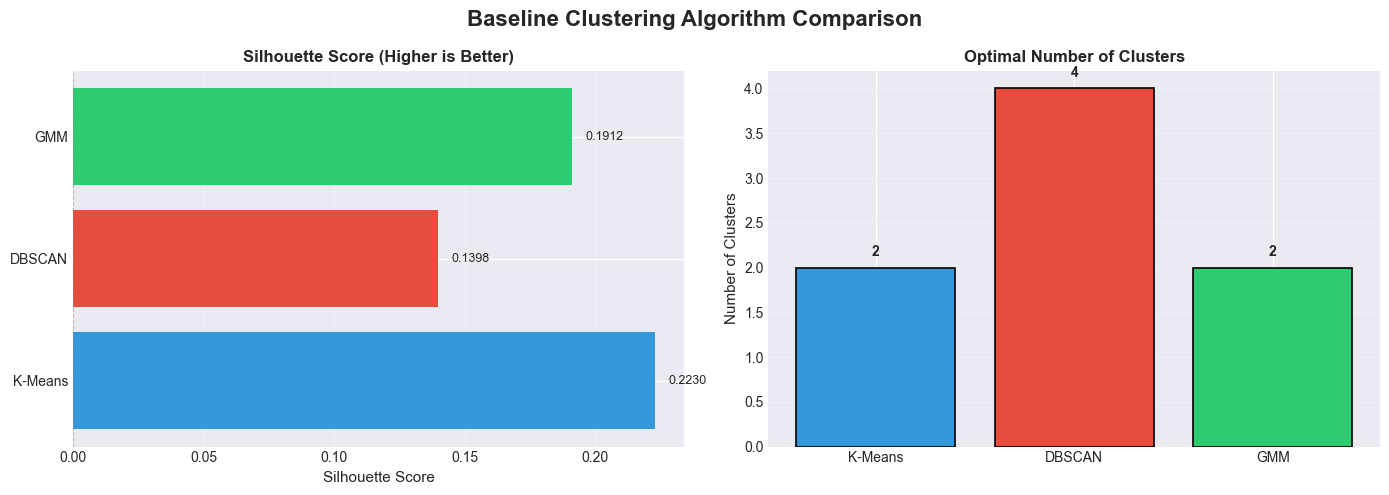


✅ Visualization completed successfully!


In [24]:
# ============================================================
# CELL 15: Baseline Clustering Visualization (COMPLETE)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

print("\n" + "="*70)
print("📊 CREATING COMPARISON VISUALIZATION (4 PANELS)")
print("="*70)

# Load summary
summary_path = Path('../reports/results/baseline_clustering_summary.csv')
df_summary = pd.read_csv(summary_path)

print(f"\n📋 Loaded summary from: {summary_path}")
print(f"   Total algorithms: {len(df_summary)}")

# Filter completed algorithms ONLY
df_completed = df_summary[df_summary['Status'] == 'Completed'].copy()

print(f"   Completed algorithms: {len(df_completed)}")
print(f"   Algorithms: {', '.join(df_completed['Algorithm'].tolist())}")

if len(df_completed) == 0:
    print("\n⚠️  No completed algorithms to visualize!")
else:
    # Convert numeric columns
    numeric_cols = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'n_clusters']
    for col in numeric_cols:
        if col in df_completed.columns:
            df_completed[col] = pd.to_numeric(df_completed[col], errors='coerce')
    
    # Drop rows with NaN in Silhouette
    df_completed = df_completed.dropna(subset=['Silhouette'])
    
    print(f"\n✅ Valid data for visualization: {len(df_completed)} algorithms")
    
    # Create 2x2 figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 11))
    fig.suptitle('Baseline Clustering Algorithm Comparison', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Color palette
    colors = {
        'K-Means': '#3498db',
        'DBSCAN': '#e74c3c',
        'GMM': '#2ecc71'
    }
    bar_colors = [colors.get(algo, '#95a5a6') for algo in df_completed['Algorithm']]
    
    # ============================================================
    # 1. Silhouette Score (Top Left)
    # ============================================================
    ax1 = axes[0, 0]
    bars1 = ax1.barh(df_completed['Algorithm'], df_completed['Silhouette'], 
                     color=bar_colors, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Silhouette Score', fontsize=12, fontweight='bold')
    ax1.set_title('Silhouette Score (Higher is Better)', fontsize=13, fontweight='bold')
    ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.7)
    ax1.set_xlim(0, max(df_completed['Silhouette']) * 1.15)
    
    # Add value labels
    for i, (idx, row) in enumerate(df_completed.iterrows()):
        value = row['Silhouette']
        ax1.text(value + 0.005, i, f"{value:.4f}", 
                va='center', fontsize=11, fontweight='bold')
    
    # Highlight best
    best_silhouette_idx = df_completed['Silhouette'].idxmax()
    best_silhouette_pos = df_completed.index.get_loc(best_silhouette_idx)
    bars1[best_silhouette_pos].set_edgecolor('gold')
    bars1[best_silhouette_pos].set_linewidth(3)
    
    # ============================================================
    # 2. Davies-Bouldin Score (Top Right)
    # ============================================================
    ax2 = axes[0, 1]
    bars2 = ax2.barh(df_completed['Algorithm'], df_completed['Davies-Bouldin'], 
                     color=bar_colors, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Davies-Bouldin Score', fontsize=12, fontweight='bold')
    ax2.set_title('Davies-Bouldin Score (Lower is Better)', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.7)
    ax2.set_xlim(0, max(df_completed['Davies-Bouldin']) * 1.15)
    
    # Add value labels
    for i, (idx, row) in enumerate(df_completed.iterrows()):
        value = row['Davies-Bouldin']
        ax2.text(value + 0.08, i, f"{value:.2f}", 
                va='center', fontsize=11, fontweight='bold')
    
    # Highlight best (lowest)
    best_db_idx = df_completed['Davies-Bouldin'].idxmin()
    best_db_pos = df_completed.index.get_loc(best_db_idx)
    bars2[best_db_pos].set_edgecolor('gold')
    bars2[best_db_pos].set_linewidth(3)
    
    # ============================================================
    # 3. Number of Clusters (Bottom Left)
    # ============================================================
    ax3 = axes[1, 0]
    bars3 = ax3.bar(df_completed['Algorithm'], df_completed['n_clusters'], 
                    color=bar_colors, edgecolor='black', linewidth=1.5, width=0.6)
    ax3.set_ylabel('Number of Clusters', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Algorithm', fontsize=12, fontweight='bold')
    ax3.set_title('Optimal Number of Clusters', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3, linestyle=':', linewidth=0.7)
    ax3.set_ylim(0, max(df_completed['n_clusters']) * 1.2)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(df_completed.iterrows()):
        value = row['n_clusters']
        ax3.text(i, value + 0.15, f"{int(value)}", 
                ha='center', va='bottom', fontsize=13, fontweight='bold')
    
    # ============================================================
    # 4. Algorithm Status Summary (Bottom Right)
    # ============================================================
    ax4 = axes[1, 1]
    status_counts = df_summary['Status'].value_counts()
    
    colors_pie = {
        'Completed': '#2ecc71',
        'Unsuitable': '#e74c3c',
        'Infeasible': '#f39c12'
    }
    pie_colors = [colors_pie.get(status, '#95a5a6') for status in status_counts.index]
    
    wedges, texts, autotexts = ax4.pie(
        status_counts, 
        labels=[f"{label}\n({count})" for label, count in zip(status_counts.index, status_counts)],
        autopct='%1.0f%%',
        startangle=90,
        colors=pie_colors,
        textprops={'fontsize': 11, 'weight': 'bold'},
        explode=[0.05 if status == 'Completed' else 0 for status in status_counts.index]
    )
    ax4.set_title('Algorithm Status Summary', fontsize=13, fontweight='bold')
    
    # Make percentage text more visible
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(12)
        autotext.set_weight('bold')
    
    plt.tight_layout()
    
    # Save figure
    figures_dir = Path('../reports/figures')
    figures_dir.mkdir(parents=True, exist_ok=True)
    fig_path = figures_dir / 'baseline_comparison_summary.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    print(f"\n💾 Visualization saved to: {fig_path}")
    print(f"   Absolute path: {fig_path.resolve()}")
    print(f"   Resolution: 300 DPI")
    
    plt.show()
    
    # Print summary stats
    print(f"\n📊 Visualization Summary:")
    print(f"   Best Silhouette: {df_completed.loc[df_completed['Silhouette'].idxmax(), 'Algorithm']} ({df_completed['Silhouette'].max():.4f})")
    print(f"   Best Davies-Bouldin: {df_completed.loc[df_completed['Davies-Bouldin'].idxmin(), 'Algorithm']} ({df_completed['Davies-Bouldin'].min():.4f})")
    print(f"   Cluster range: {int(df_completed['n_clusters'].min())}-{int(df_completed['n_clusters'].max())}")
    
    print("\n✅ Visualization completed successfully!")

print("="*70)


In [25]:
# Cell 16: MLflow Experiment Summary
print("\n" + "="*60)
print("🔬 MLFLOW EXPERIMENT SUMMARY")
print("="*60)

# Get all runs from experiment
experiment = mlflow.get_experiment_by_name('baseline-clustering-v2')
all_runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

print(f"\n📊 Total Runs Logged: {len(all_runs)}")
print(f"\n🔗 MLflow UI: http://localhost:5002/#/experiments/{experiment.experiment_id}")

# Count by algorithm
if 'tags.algorithm' in all_runs.columns:
    algo_counts = all_runs['tags.algorithm'].value_counts()
    print("\n📋 Runs by Algorithm:")
    for algo, count in algo_counts.items():
        print(f"   {algo}: {count} runs")

# Top 5 runs by silhouette score
if 'metrics.silhouette_score' in all_runs.columns:
    top_5 = all_runs.nlargest(5, 'metrics.silhouette_score')[[
        'tags.algorithm', 'metrics.silhouette_score', 
        'metrics.davies_bouldin_score', 'metrics.calinski_harabasz_score'
    ]]
    print("\n🏆 Top 5 Runs by Silhouette Score:\n")
    print(top_5.to_string(index=False))

print("\n" + "="*60)
print("✅ BASELINE CLUSTERING EXPERIMENTS COMPLETED!")
print("="*60)
print("\n📌 Next Steps:")
print("   1. Review results in MLflow UI")
print("   2. Analyze cluster characteristics")
print("   3. Proceed to Deep Clustering (DEC/IDEC) development")
print("   4. Compare baseline vs. deep clustering performance")


🔬 MLFLOW EXPERIMENT SUMMARY

📊 Total Runs Logged: 46

🔗 MLflow UI: http://localhost:5002/#/experiments/451624598823372885

📋 Runs by Algorithm:
   gmm: 36 runs
   kmeans: 9 runs

🏆 Top 5 Runs by Silhouette Score:

tags.algorithm  metrics.silhouette_score  metrics.davies_bouldin_score  metrics.calinski_harabasz_score
        kmeans                  0.222960                      2.330145                      5026.192411
           gmm                  0.191177                      3.118004                      4163.351128
           gmm                  0.185343                      3.489224                      3679.342153
           gmm                  0.164542                      4.819748                      2605.315654
           gmm                  0.076146                      3.478947                      4803.124926

✅ BASELINE CLUSTERING EXPERIMENTS COMPLETED!

📌 Next Steps:
   1. Review results in MLflow UI
   2. Analyze cluster characteristics
   3. Proceed to Deep Cluste